In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io, manipulate, target_comparison, subtract
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

import altair as alt

import plotly.express as px

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [12]:
background_fps = ['/home/bgpelkie/Research/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_10_15_Highlights_replicates/03357_D5-T2_Background_1_EtOH_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_11_05_optimizationRound1/03533_F9-T1_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_11_12_optimizationRound2/data/03619_B11-T2_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_11_15_optimizationRound3/03644_B9-T2_Ethanol_background_1_000.dat',
                  '/home/bgpelkie/Research/SAXS_data/2024_11_18_optimizationRound4/03667_E11-T2__Ethanol_background_1__000.dat']

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [13]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1024 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [14]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [15]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## load data

In [17]:
sample_data, uuid2bkg, _ = io.load_biocube_data_with_background(background_fps, 24)

## Run full processing pipeline

In [21]:
processing_dataset = {}
for uuid_val, data_val in sample_data.items():
   
    data_val = sample_data[uuid_val]
    meas_entry = {}
    meas_entry['original_data'] = data_val[0]
    background = uuid2bkg[uuid_val]
    meas_entry['background'] = background[0]
    # 1. Subtract background and select q range
    subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
    
    fig, ax = plt.subplots(figsize = (6,4))
    ax.set_title(uuid_val)
    if subtracted is None:
        ax.text(0.5, 0.5, 'Failed Subtraction')
    else:
        subtracted = subtracted[subtracted['q'] < q_max_subtract]
        subtracted = subtracted[~subtracted['I'].isna()]
        subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
        
        ax.loglog(subtracted['q'], subtracted['I'])
        ax.set_xlabel('q (A)')
    plt.tight_layout()
    plt.savefig(f'viz_figs/{uuid_val}.png', dpi = 100)
    plt.close()


## prep a df 

In [22]:
synth_data = pd.read_csv('../2024_11_21_Optimization5/synth_table_ap_distance_11_21_24.csv')

In [41]:
for item in synth_data['uuid'].to_list():
    if 'd8a1' in item:
        print(item)

d8a17275-4162-4633-bb9d-09d514ab7cb9


In [42]:
synth_data['exp_apdist'] = np.exp(synth_data['ap_distance'])

In [43]:
synth_data[synth_data['uuid'] == 'd8a17275-4162-4633-bb9d-09d514ab7cb9']

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,campaign,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,experiment_status,rank,exp_apdist,image
198,d8a17275-4162-4633-bb9d-09d514ab7cb9,17.0,33.144234,144.481243,1505.374523,2.232143,2.691584,0.00332,2024_11_14_OptimRound3,1700.0,0.01,0.019497,0.084989,0.885514,0.916576,complete,11.0,2.500714,https://upconverting.blob.core.windows.net/sil...


In [26]:
filepaths = [f'https://upconverting.blob.core.windows.net/silica-np-saxs/{uuid}.png' for uuid in synth_data['uuid']] 

In [27]:
synth_data['image'] = filepaths

In [32]:
chart = alt.Chart(synth_data, width = 600, height = 500).mark_circle(size=100).encode(
    x = 'teos_vol_frac',
    y = 'water_vol_frac',
    color = 'exp_apdist',
    tooltip=['uuid', 'image', 'ap_distance', 'rank', 'campaign'])

#chart['usermeta'] = {
#    "embedOptions": {
#        'loader': {'target': '_blank'}
#    }
#}

In [33]:
chart

alt.Chart(...)

In [36]:
chart = alt.Chart(synth_data, width = 600, height = 500).mark_circle(size=100).encode(
    x = 'teos_vol_frac',
    y = 'ammonia_vol_frac',
    color = 'exp_apdist',
    tooltip=['uuid', 'image', 'ap_distance', 'water_vol_frac', 'exp_apdist'])

In [37]:
chart

alt.Chart(...)

### 3D viz

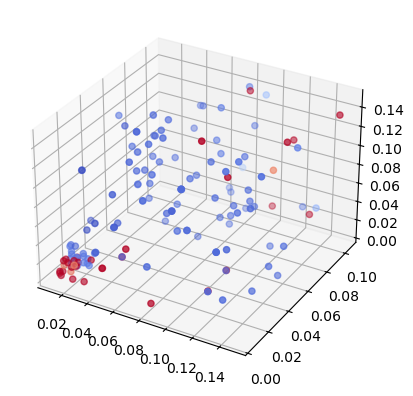

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], synth_data['water_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm)

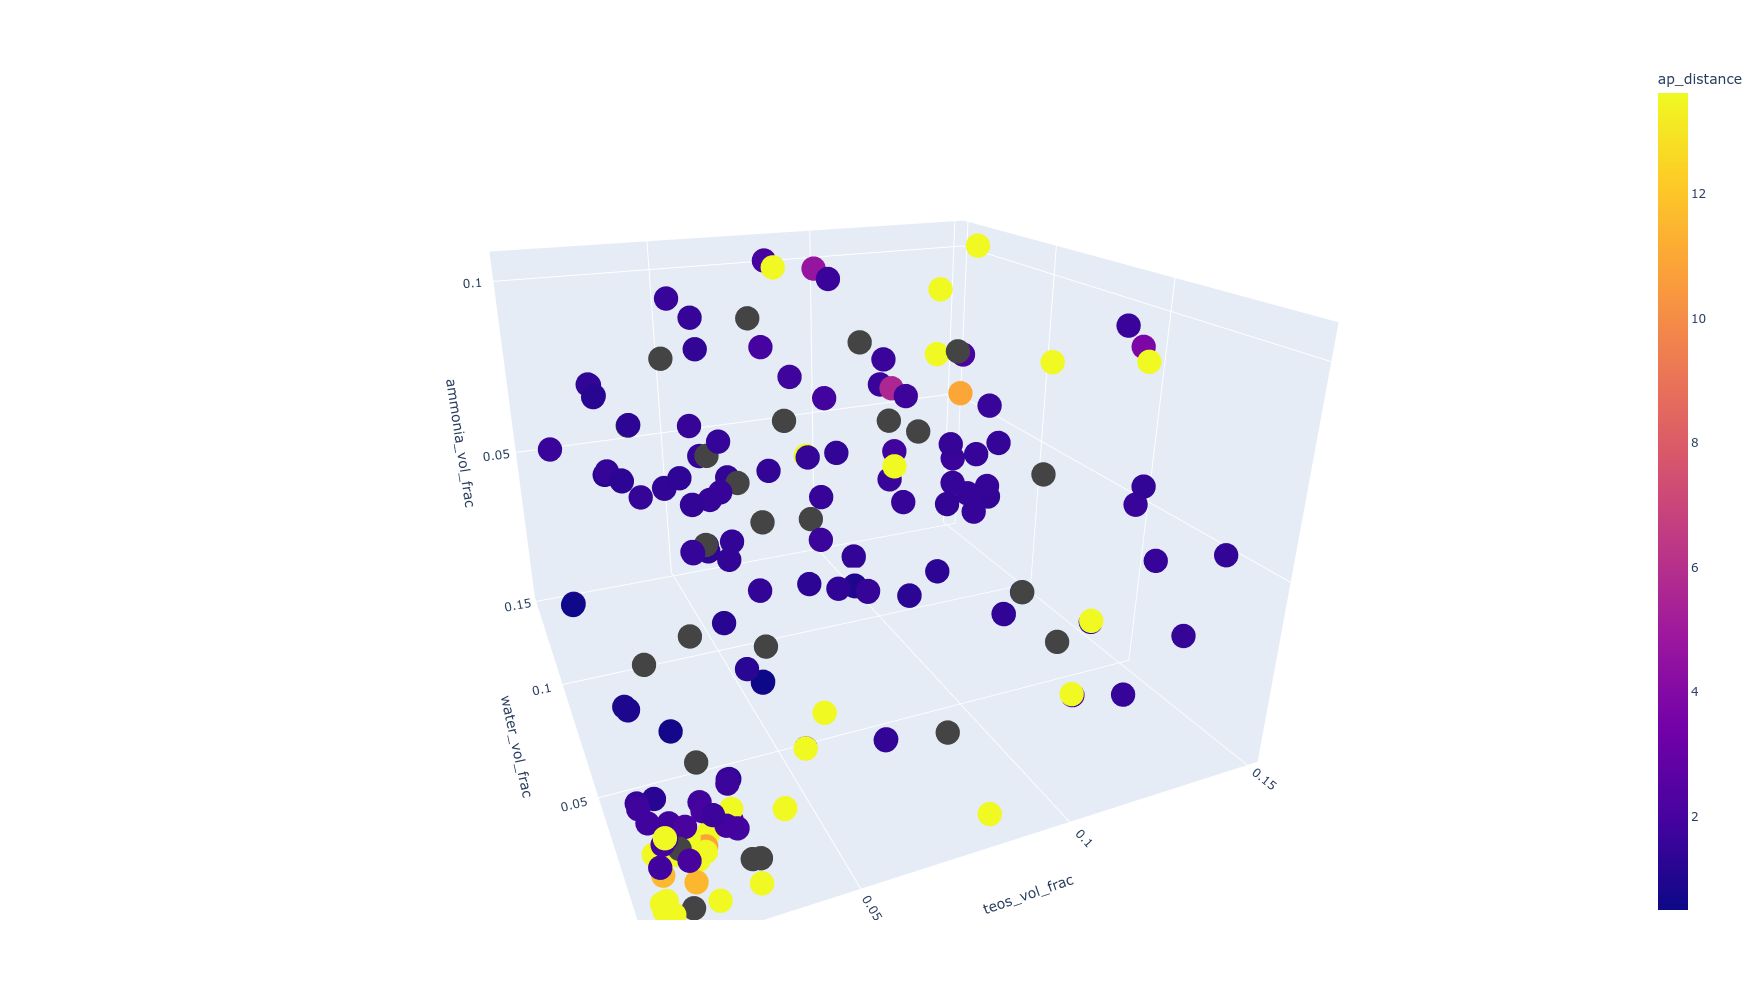

In [20]:
import plotly.express as px
fig = px.scatter_3d(synth_data, x='teos_vol_frac', y='water_vol_frac', z='ammonia_vol_frac',
              color='ap_distance', width=1000, height = 1000)
fig.show()